All instructions are provided for R. I am going to reproduce them in Python as best as I can.

# Preface

From the textbook, p. 123:
> This question involves the use of multiple linear regression on the
`Auto` data set.

In [12]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

from my_utils import lm_plot


sns.set()
%matplotlib inline

In [13]:
carseats = pd.read_csv('carseats.csv')
carseats.head(3)

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes


Columns:
1. `Sales` &mdash; unit sales (in thousands) at each location.
1. `CompPrice` Price charged by competitor at each location.
1. `Income` &mdash; community income level (in thousands of dollars).
1. `Advertising` &mdash; local advertising budget for company at each location (in thousands of dollars).
1. `Population` &mdash; population size in region (in thousands).
1. `Price` &mdash; price company charges for car seats at each site.
1. `ShelveLoc` &mdash; a factor with levels Bad, Good and Medium indicating the quality of the shelving location for the car seats at each site.
1. `Age` &mdash; average age of the local population.
1. `Education` &mdash; education level at each location.
1. `Urban` &mdash; a factor with levels No and Yes to indicate whether the store is in an urban or rural location.
1. `US` &mdash; a factor with levels No and Yes to indicate whether the store is in the US or not.

`ShelveLoc`, `Urban`, and `US` are categorical variables.


In [14]:
carseats = carseats.astype({'ShelveLoc' : 'category'
                            , 'Urban' : 'category'
                            , 'US' : 'category'
                           }
                          )

x = carseats.drop('Sales', axis='columns')
x['Intercept'] = 1
x = pd.get_dummies(x, drop_first=True)
y = carseats.Sales

# (a)

From the textbook, p. 123
> Fit a multiple regression model to predict `Sales` using `Price`, `Urban`, and `US`.

In [15]:
model_a = sm.regression.linear_model.OLS(y, x[['Intercept'
                                             , 'Price'
                                             , 'Urban_Yes'
                                             , 'US_Yes'
                                            ]
                                           ]
                                      ).fit()

# (b)

From the textbook, p. 123
> Provide an interpretation of each coefficient in the model. Be careful &mdash; some of the variables in the model are qualitative!

In [16]:
model_a.params

Intercept    13.043469
Price        -0.054459
Urban_Yes    -0.021916
US_Yes        1.200573
dtype: float64

1. For each dollar increase in price, sales go down by 54 units.
1. If a store is in urban area, sales are fewer by 22 units.
1. If a store is in the US, sales are higher by 1200 units.
1. If a store in a rural area outside of the US sets the price of a carseat to 0, it sells 13043 units.

# (c)

From the textbook, p. 123
> Write out the model in equation form, being careful to handle the qualitative variables properly.

$$ \widehat{Sales} = 13.043469 - 0.054459 \cdot Price - 0.021916 \cdot Urban' + 1.200573 \cdot US', $$

where
$$
Urban' = \begin{cases}
          1, \; \text{if} \; Urban \; \text{is "Yes"} \\
          0, \; \text{if} \; Urban \; \text{is "No"} \\
        \end{cases}
$$
and
$$
US' = \begin{cases}
        1, \; \text{if} \; US \; \text{is "Yes"} \\
        0, \; \text{if} \; US \; \text{is "No"} \\
      \end{cases}
$$

# (d)

From the textbook, p. 123
> For which of the predictors can you reject the null hypothesis $H_0: \beta_j = 0$?

In [17]:
model_a.pvalues

Intercept    3.626602e-62
Price        1.609917e-22
Urban_Yes    9.357389e-01
US_Yes       4.860245e-06
dtype: float64

For `Price` and `US`.

# (e)

From the textbook, p. 123
> On the basis of your response to the previous question, fit a smaller model that only uses the predictors for which there is evidence of association with the outcome.

In [18]:
model_e = sm.regression.linear_model.OLS(y, x[['Intercept'
                                             , 'Price'
                                             , 'US_Yes'
                                            ]
                                           ]
                                      ).fit()

# (f)

From the textbook, p. 123
> How well do the models in (a) and (e) fit the data?

In [19]:
print(f'R squared for model in (a): {model_a.rsquared:.3f}\n'
      f'R squared for model in (e): {model_e.rsquared:.3f}'
)

R squared for model in (a): 0.239
R squared for model in (e): 0.239


They both do equally poorly.

# (g)

From the textbook, p. 123
> Using the model from (e), obtain 95% confidence intervals for the coefficient(s).

In [20]:
model_e.conf_int(alpha=0.05).rename(columns={0 : 'lower', 1 : 'upper'})

,lower,upper
Intercept,11.79032,14.271265
Price,-0.06476,-0.044195
US_Yes,0.69152,1.707766


# (h)

From the textbook, p. 123
> Is there evidence of outliers or high leverage observations in the model from (e)?

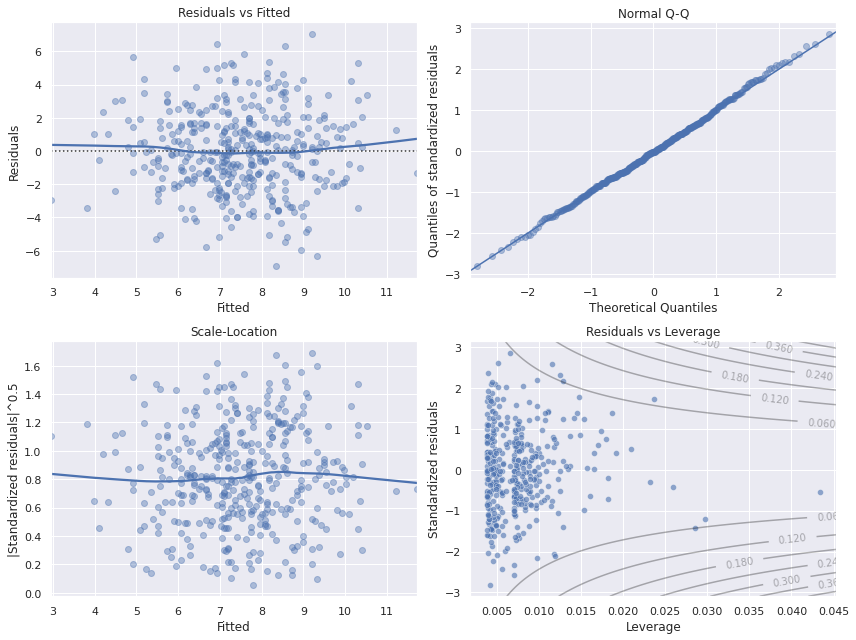

In [21]:
model_e.outlier_test()[model_e.outlier_test().unadj_p < 0.01]
lm_plot(model_e)
plt.tight_layout()

In [22]:
influence = model_e.get_influence()
st_residuals = influence.resid_studentized_internal
leverages = influence.hat_matrix_diag
print('Would-be outliers:', np.where((st_residuals > 2)
                                     | (st_residuals < -2)
                                    )[0]
)
print('Points with high leverages:', np.where(leverages > 0.025)[0])

Would-be outliers: [ 17  25  28  30  49  50  57  62  68  82  98 106 143 209 258 297 298 304
 316 328 352 376 395]
Points with high leverages: [ 42 125 165 174]


Judging by Cook's distance, none of the points have high influence on the fit. There is no points with studentized residuals greater than 3 (by absolute value) and 23 points with studentized residuals greater than 2 (by absolute value). The textbook does not give a strict criterion for determining a point with high leverage. I have arbitrarily chose 0.025, and there are 4 points with leverage greater than that.